Initial code to investigate basic RL model for price minimisation of HVAC system.

States:
    - Room temp
    - External temp
    - Elec price

Action:
    - Choose temp setpoint

Training methodology

1. For each hourly timestep:
    - Load internal temp, external temp, and current electricity price (states)
    - Choose temperature setpoint (action)
    - Simulate 60 mins of PI controller working
        - Re calculating required heat load (Q_hvac) at each minute
        - Step building thermal model 1 min (simulation_enviornment) to calc new internal temperature
    - Final internal temperature calculation from thermal model (60th value) is internal temperature for next step
    - Calculate reward

Measured data required:
    - Only need measurements for external temperature and electricity price
    - Internal temperature can be initialised to any value close to desired setpoint,
      then calculated from building thermal model
    - Temperature setpoint chosen by RL agent
    - HVAC heat load calculated from PI controller


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import open_close_rl as orl
import rl_per_week as trl
import basicPI as bpi
import rl_basic as rlb
import rl_basic_pricing as rlp
import numpy as np

In [3]:
#Prices May-July 2022
testprices = pd.read_csv("./input_data/3 year N2EX elec Prices.csv")
testprices = pd.concat([testprices.iloc[20448:27792]] * 5)
#Temperatures May-July 2023
external_temps = pd.read_csv("./input_data/measured_external_temps_01052022-01042023.csv", index_col = 0)
external_temps = pd.concat([external_temps.iloc[25:7369]] * 5)
#external_temps[:,0]= pd.to_datetime(external_temps[:,0], utc=True)
external_temps.iloc[0], testprices.iloc[0]

(temperature_0    9.25
 Name: 2022-05-02 01:00:00+01:00, dtype: float64,
 Timestamp        02/05/2022 00:00
 Price (£/kWh)             0.09999
 Name: 20448, dtype: object)

In [4]:
pi = bpi.PI()
pi.run(external_temps, testprices)

In [7]:
sum(pi.bmoneys[-8736:-1])

102122444.27368025

In [ ]:
thousand_agent = orl.EpsilonGreedy(0.04)
thousand_agent.run(0.4, 0.5,external_temps,testprices, comfortweight=2)

(89, 14, 18, 2, 14)


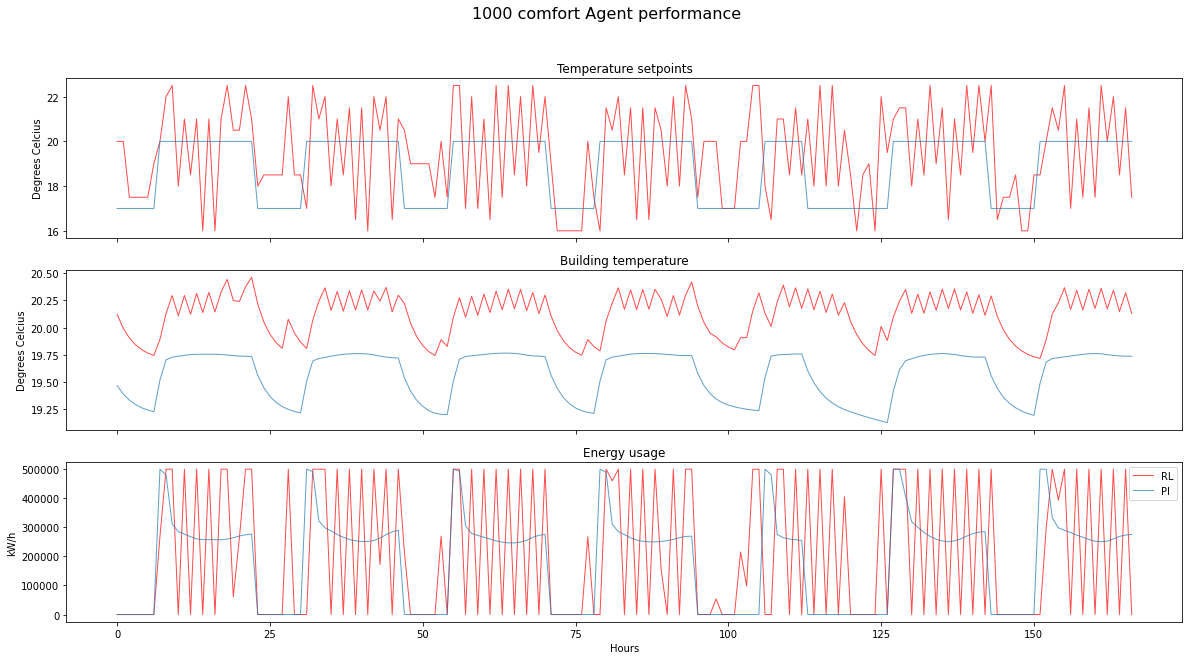

In [ ]:
period = 168

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(thousand_agent.tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('1000 comfort Agent performance', fontsize=16)
axs[1].plot(thousand_agent.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(thousand_agent.energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[-period:-1], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
thousand_agent.greedyrun(22032,external_temps,testprices)

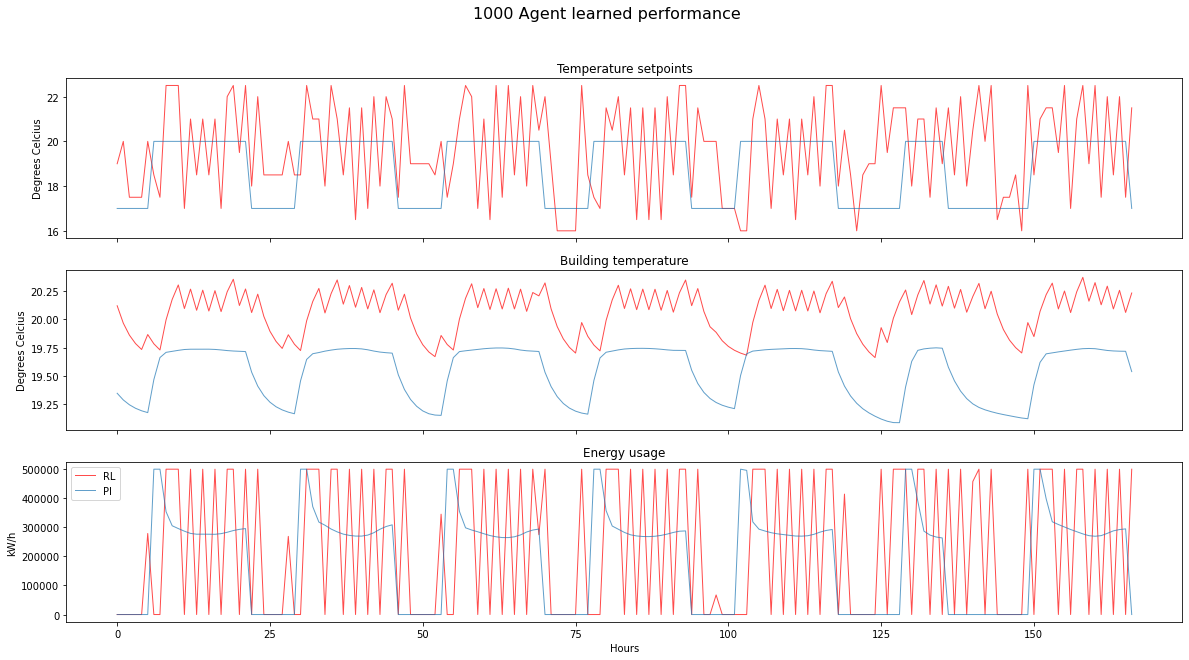

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(thousand_agent.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('1000 Agent learned performance', fontsize=16)
axs[1].plot(thousand_agent.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(thousand_agent.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

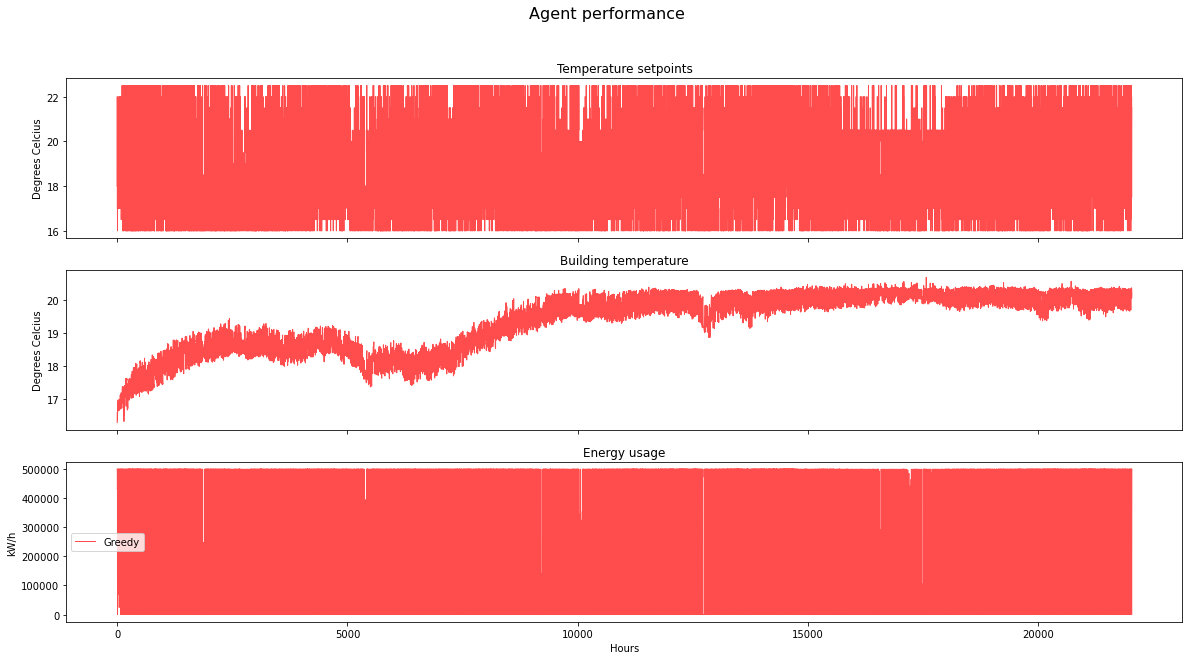

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(thousand_agent.learned_tempsets, alpha=0.7, linewidth=1, label='Greedy', color='red')
#axs[0].plot(range(n),epsilongreedy1.average_rewards, alpha=0.7, linewidth=1, label='0.1')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Agent performance', fontsize=16)
axs[1].plot(thousand_agent.learned_buildingtemps, alpha=0.7, linewidth=1, label='Greedy', color='red')
#axs[1].plot(range(n),epsilongreedy1.optimal_action_percent, alpha=0.7, linewidth=1, label='0.1')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(thousand_agent.learned_energy, alpha=0.7, linewidth=1, label='Greedy', color='red')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
fivehundredagent = orl.EpsilonGreedy(0.04)
fivehundredagent.run(0.4, 0.5,external_temps,testprices)
fivehundredagent.greedyrun(22032,external_temps,testprices)

(89, 14, 18, 2, 14)


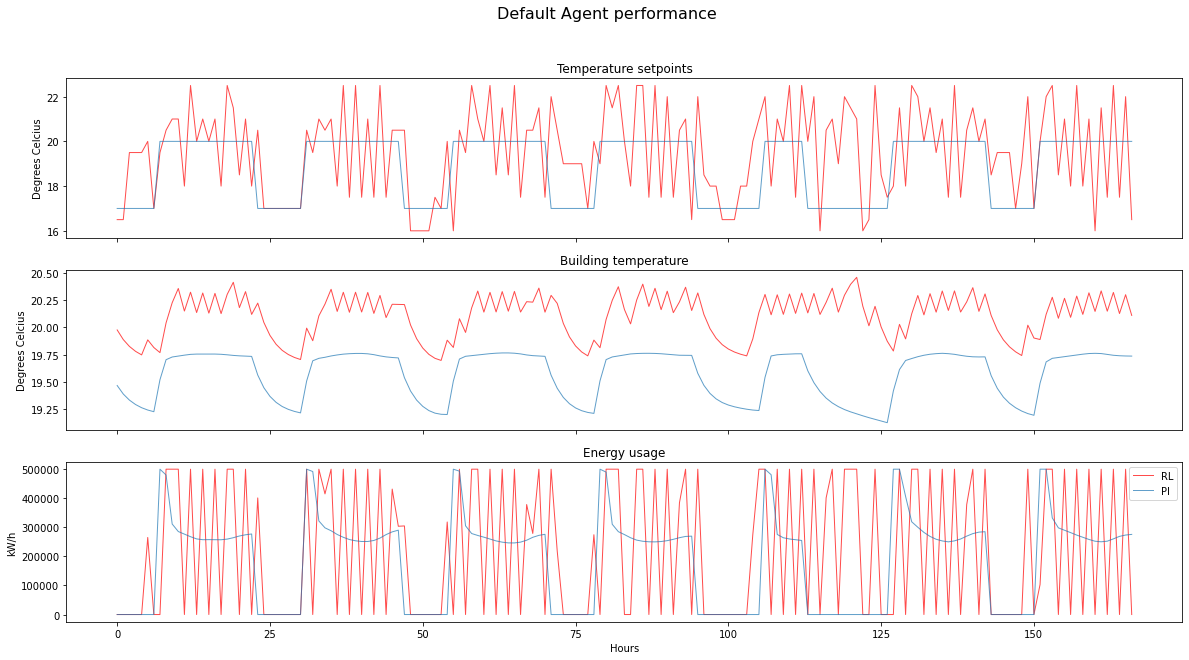

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(fivehundredagent.tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Default Agent performance', fontsize=16)
axs[1].plot(fivehundredagent.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(fivehundredagent.energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[-period:-1], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

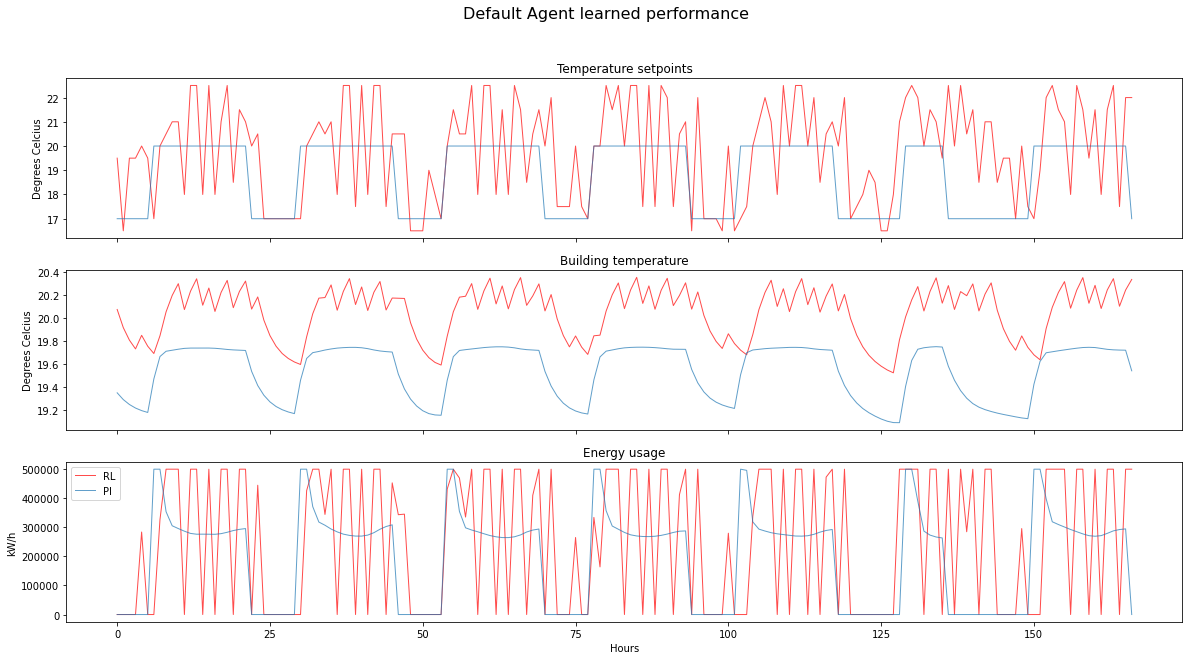

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(fivehundredagent.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Default Agent learned performance', fontsize=16)
axs[1].plot(fivehundredagent.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(fivehundredagent.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
timeagent = trl.EpsilonGreedy(0.04)
timeagent.run(0.4, 0.5,external_temps,testprices)

(89, 14, 7, 24, 14)


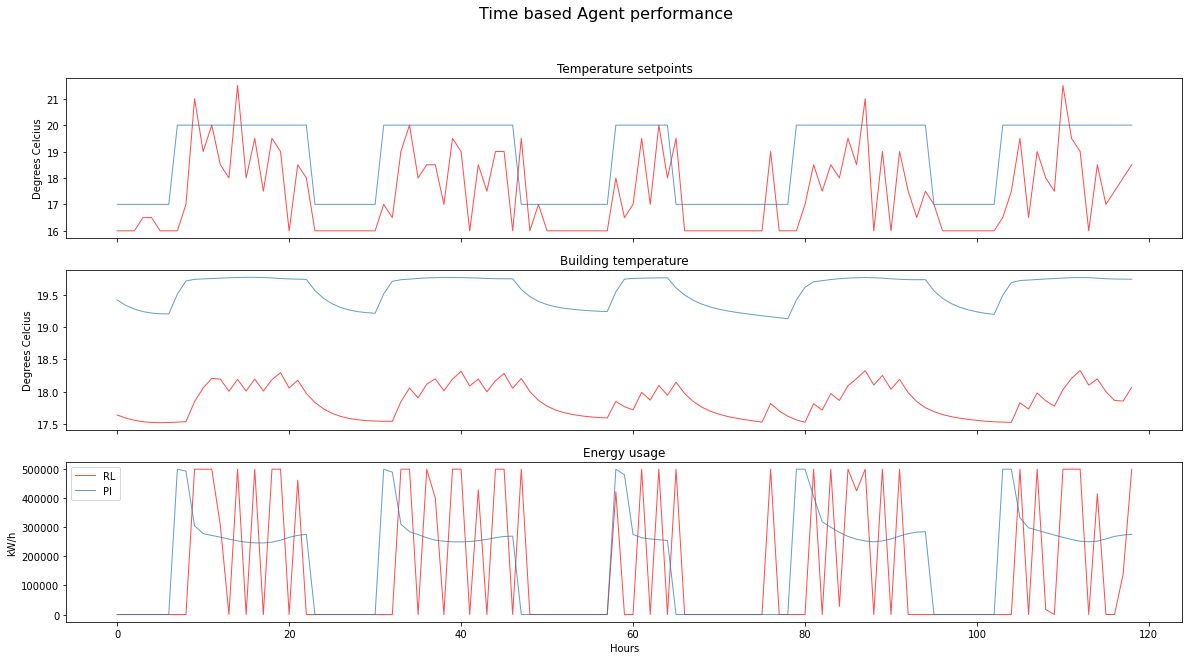

In [ ]:
period = 120

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent.tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time based Agent performance', fontsize=16)
axs[1].plot(timeagent.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent.energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[-period:-1], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
timeagent2 = trl.EpsilonGreedy(0.9)
timeagent2.run(0.4, 0.95,external_temps,testprices, comfortweight=2)
timeagent2.greedyrun(22032,external_temps,testprices)

(89, 14, 7, 24, 14)


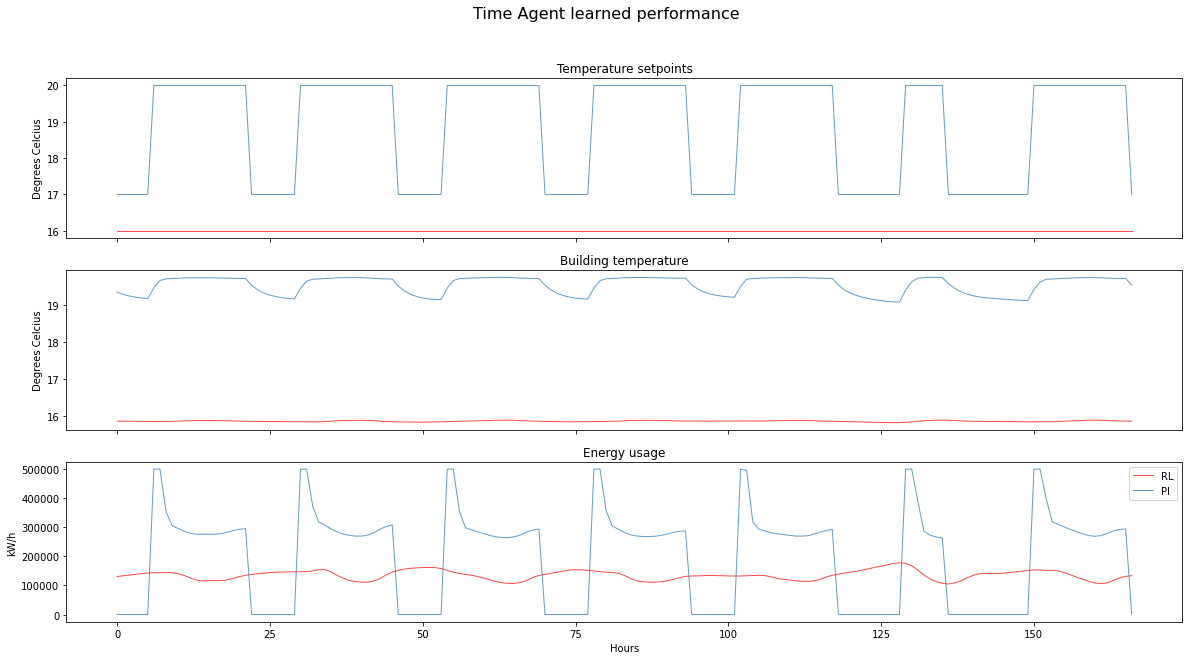

In [ ]:
period = 168

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent2.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time Agent learned performance', fontsize=16)
axs[1].plot(timeagent2.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent2.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
timeagent3 = trl.EpsilonGreedy(0.9)
timeagent3.run(0.4, 0.95,external_temps,testprices, comfortweight=10)
timeagent3.greedyrun(22032,external_temps,testprices)

(89, 14, 7, 24, 14)


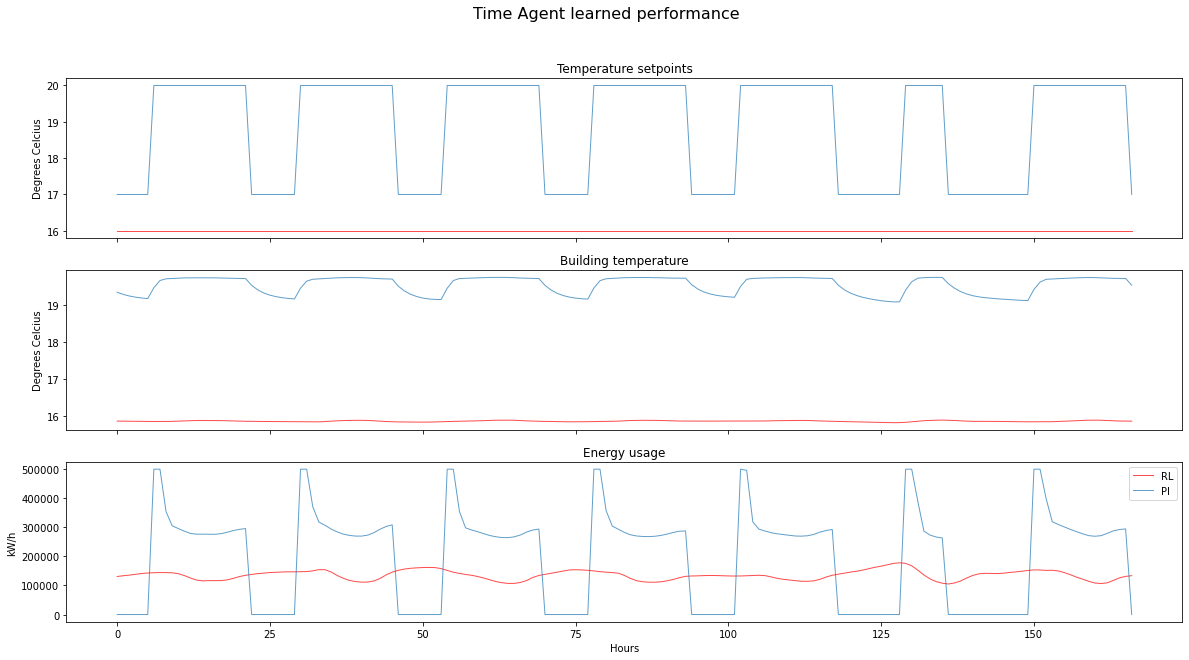

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent3.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time Agent learned performance', fontsize=16)
axs[1].plot(timeagent3.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent3.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
timeagent4 = trl.EpsilonGreedy(0.9)
timeagent4.run(0.4, 0.95,external_temps,testprices, comfortweight=0.1)
timeagent4.greedyrun(22032,external_temps,testprices)

(89, 14, 7, 24, 14)


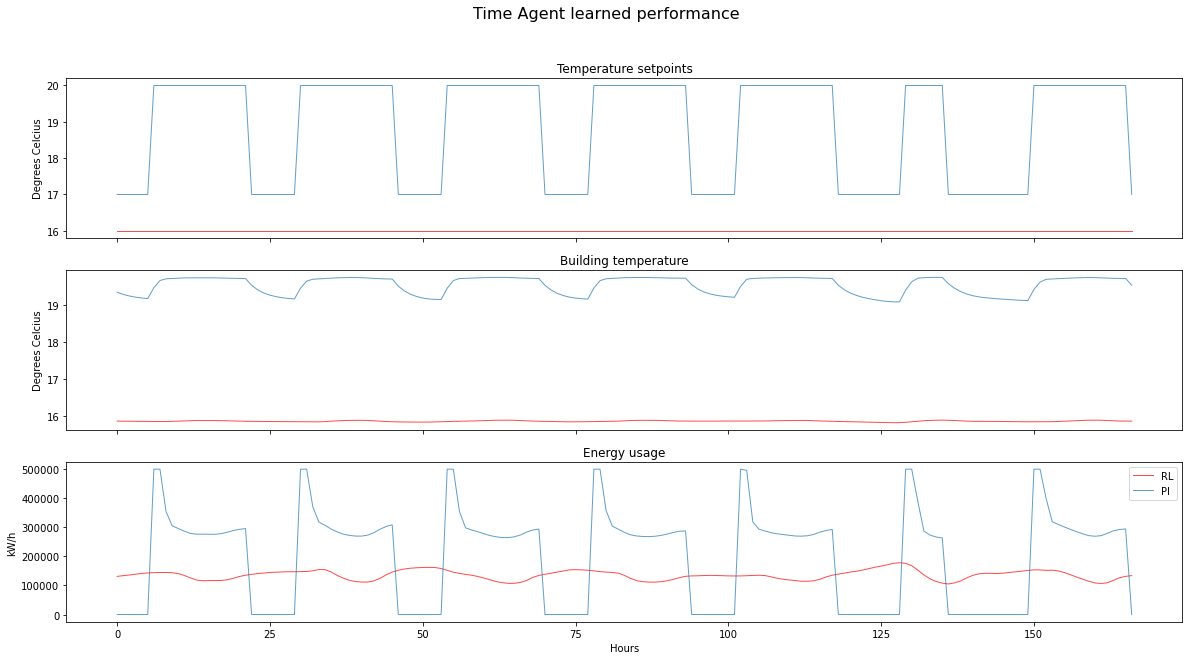

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent4.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time Agent learned performance', fontsize=16)
axs[1].plot(timeagent4.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent4.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
# Try starting at 20 degrees and making comfortweight very high. Try a slightly smaller gamma

In [ ]:
timeagent5 = trl.EpsilonGreedy(0.6)
timeagent5.run(0.4, 0.95,external_temps,testprices, comfortweight=10)
timeagent5.greedyrun(22032,external_temps,testprices)

(89, 14, 7, 24, 14)


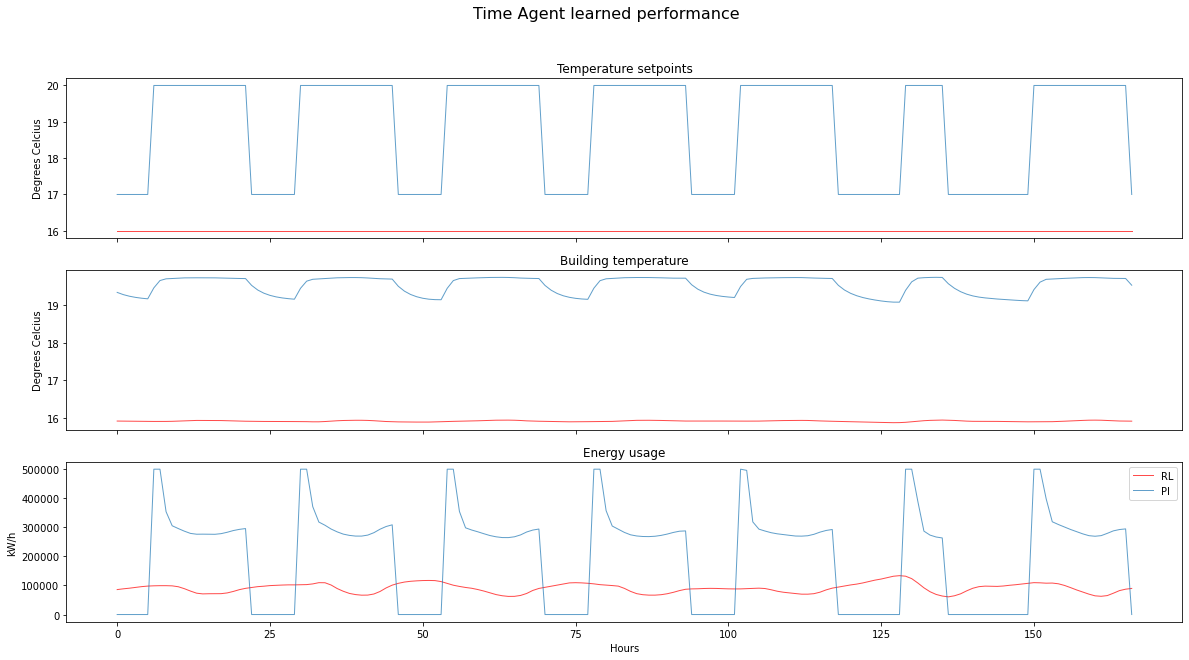

In [ ]:
period = 168
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent5.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time Agent learned performance', fontsize=16)
axs[1].plot(timeagent5.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent5.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

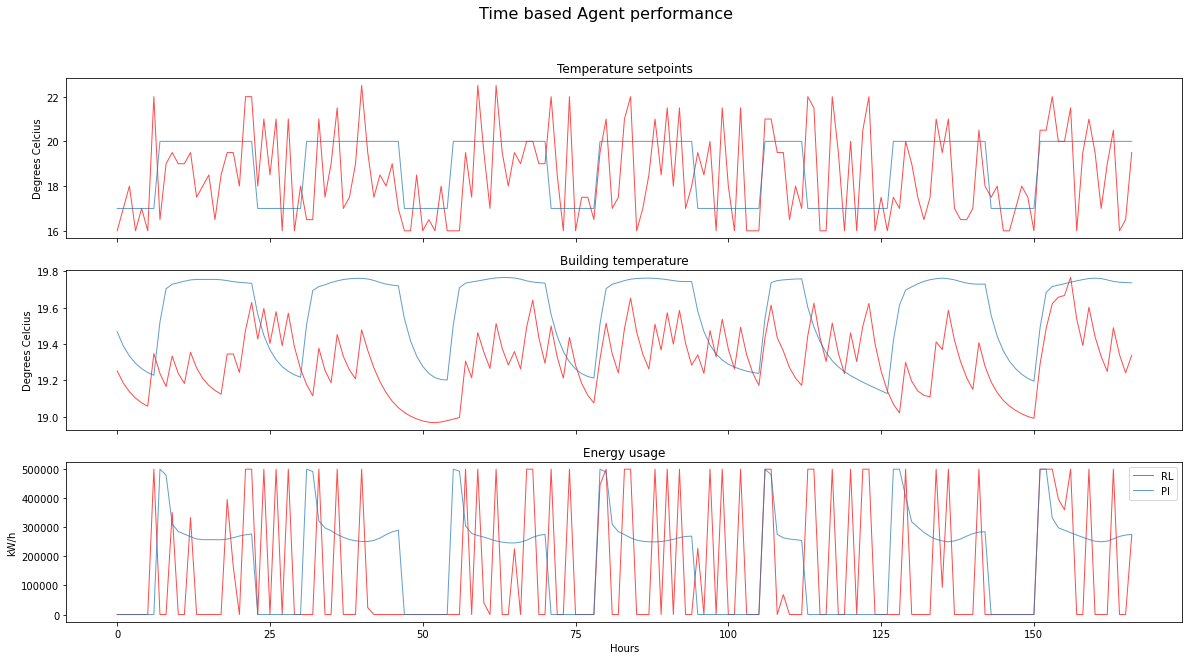

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(timeagent5.tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time based Agent performance', fontsize=16)
axs[1].plot(timeagent5.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(timeagent5.energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[-period:-1], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [ ]:
import numpy as np
a = np.count_nonzero(timeagent5.qtable == 0)
b = timeagent5.qtable.shape
b

(89, 14, 7, 24, 14)

In [ ]:
b = 89 * 14 * 7 * 24 * 14

In [ ]:
a/b

0.9759922227317893

In [159]:
basicagent = rlb.EpsilonGreedy(0.2)
basicagent.run(0.4, 0.95,external_temps,testprices, comfortweight=1)
basicagent.greedyrun(22032,external_temps,testprices)

(14, 7, 24, 14)


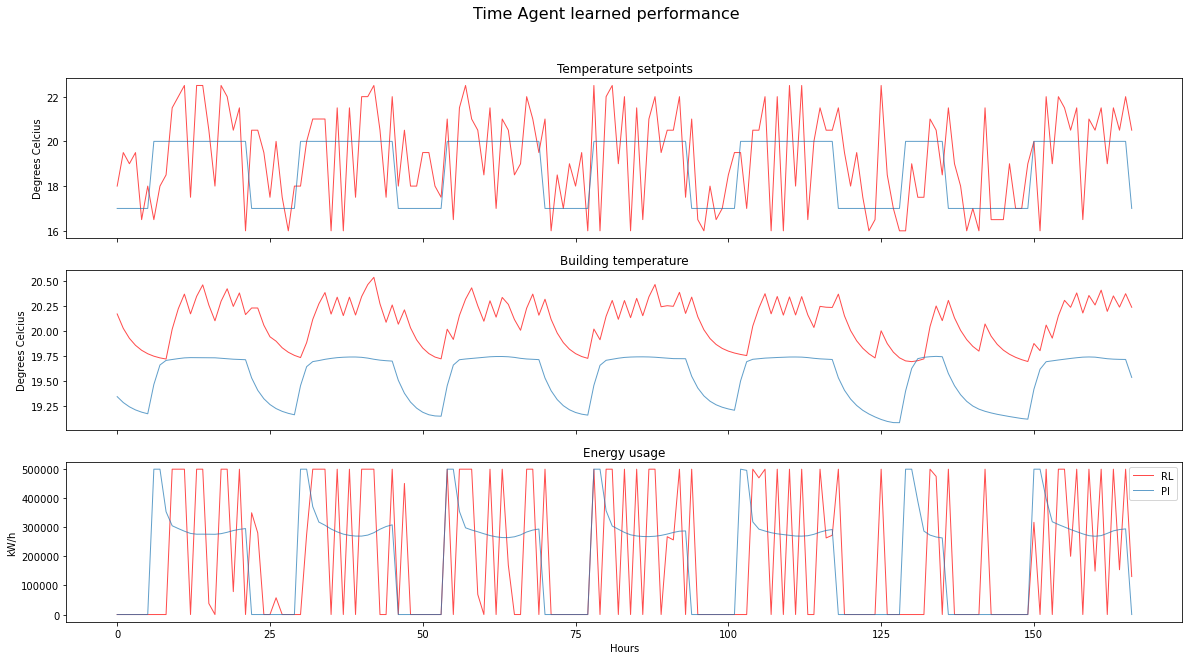

In [160]:
period = 168
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(basicagent.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Time Agent learned performance', fontsize=16)
axs[1].plot(basicagent.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(basicagent.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [144]:
import numpy as np
a = np.count_nonzero(basicagent.qtable == 0)
a /(14 * 7 * 24 * 14)

0.6673044217687075

In [145]:
basicagent.qtable[8,4,9,:]

array([-199.62 , -199.62 , -200.   , -320.   , -200.   ,    0.   ,
          0.   ,    0.   , -383.476, -335.856, -263.556,    0.   ,
       -273.72 ,    0.   ])

In [161]:
sum(basicagent.moneys[-168:-1])/100000

89.51558570477818

Text(0, 0.5, 'GBP')

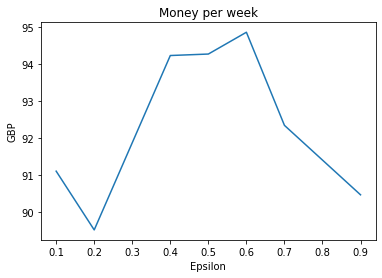

In [162]:
x = [0.1,0.2, 0.4, 0.5, 0.6, 0.7, 0.9]
y = [91.10,89.51, 94.23, 94.27,94.86, 92.34, 90.46]
plt.plot(x,y)
plt.title('Money per week')
plt.xlabel('Epsilon')
plt.ylabel('GBP')

In [4]:
basicpagent = rlp.EpsilonGreedy(0.01)
basicpagent.run(0.4, 0.99,external_temps, comfortweight=1)
basicpagent.greedyrun(22032,external_temps)

(14, 7, 24, 14)


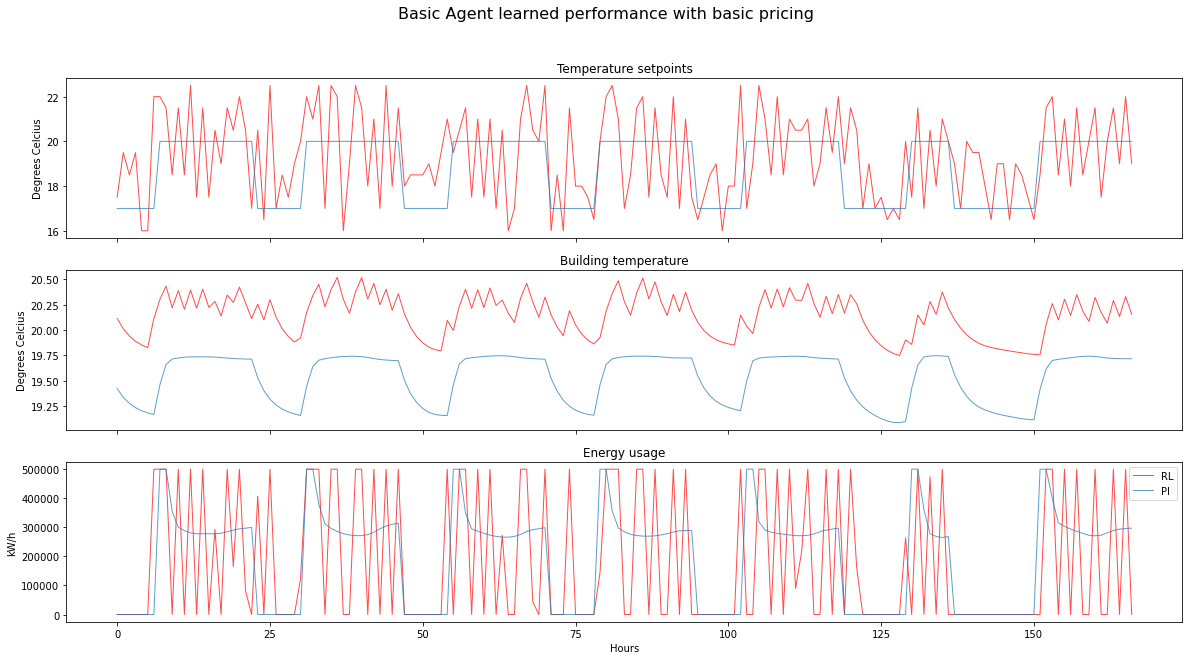

In [5]:
period = 168
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,10))
axs[0].plot(basicpagent.learned_tempsets[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[0].plot(pi.tempsets[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[0].plot(range(n),epsilongreedy2.average_rewards, alpha=0.7, linewidth=1, label='0.01')
axs[0].set_title('Temperature setpoints')
axs[0].set_ylabel('Degrees Celcius')
fig.suptitle('Basic Agent learned performance with basic pricing', fontsize=16)
axs[1].plot(basicpagent.learned_buildingtemps[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[1].plot(pi.buildingtemps[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
#axs[1].plot(range(n),epsilongreedy2.optimal_action_percent, alpha=0.7, linewidth=1, label='0.01')
axs[1].set_title('Building temperature')
axs[1].set_ylabel('Degrees Celcius')
axs[2].plot(basicpagent.learned_energy[-period:-1], alpha=0.7, linewidth=1, label='RL', color='red')
axs[2].plot(pi.energy[22032-period:22031], alpha=0.7, linewidth=1, label='PI')
axs[2].set_title('Energy usage')
axs[2].set_ylabel('kW/h')
plt.xlabel('Hours')
plt.legend()

In [10]:
sum(basicpagent.moneys[-8736:-1])/sum(pi.bmoneys[-8736:-1])

0.9348090314629045

In [7]:
basicpagent.qtable[10,2,15,:]

array([-1258.45180707, -1167.9084517 , -1130.49379517, -1253.60548575,
       -1203.29507064, -1113.50750901, -1122.81757077, -1209.96259658,
       -1229.39606568, -1116.56715927, -1140.95013544, -1102.80053696,
       -1160.47961813, -1119.07741995])

Eps:0.1:1.0638003189201164, 0.4:1.0597175188049066, 0.9:1.01849219502675(alpha 0.4)
Alpha:0.1:1.0894544345080823, 0.9:1.035637204907376
0.1,0.4,0.99,0.8: 0.9770455444454348
0.01,0.4,0.99,0.8: 0.8847481134677803
0.01,0.4,0.8,0.8: 1.0404614133024885
0.01,0.4,0.6,0.8: 1.0513108981691894
0.01,0.8,0.99,0.8: 0.952060730476818
0.01,0.6,0.99,0.8: 0.9021523575223334

Text(0, 0.5, 'GBP')

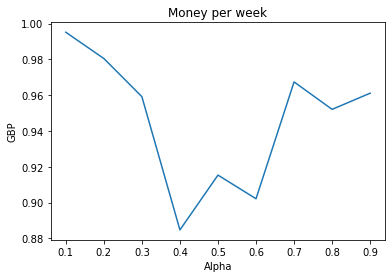

In [11]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y = [0.9951230450025738, 0.9804602712376398, 0.9591491040082214, 0.884748113467780394, 0.9153548237737894, 0.9021523575223334, 0.9673942155007633, 0.952060730476818, 0.9610960538030401]
plt.plot(x,y)
plt.title('Money per week')
plt.xlabel('Alpha')
plt.ylabel('GBP')

Text(0.5, -0.1, 'Alpha = 0.4, Gamma = 0.99, Epsilon = 0.01')

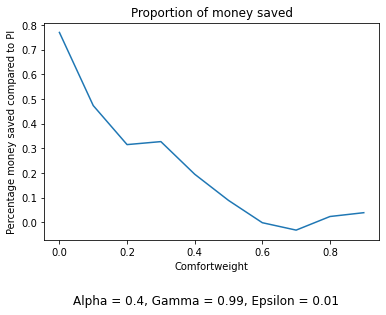

In [109]:
import numpy as np
cfl = []
for x in range(10):
    basicpagent.run(0.4, 0.99,external_temps, comfortweight=x/10)
    basicpagent.greedyrun(22032,external_temps)
    cfl.append(sum(basicpagent.moneys[-8736:-1])/sum(pi.bmoneys[-8736:-1]))
print(cfl)
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.plot(x,1-np.array(cfl))
plt.title('Proportion of money saved')
plt.xlabel('Comfortweight')
plt.ylabel('Percentage money saved compared to PI')
txt = 'Alpha = 0.4, Gamma = 0.99, Epsilon = 0.01'
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, -0.1, 'Alpha = 0.4, Gamma = 0.99, Epsilon = 0.01')

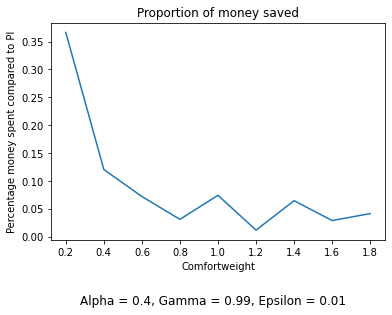

In [113]:
import numpy as np
cfl2 = []
for x in range(9):
    basicpagent.run(0.4, 0.99,external_temps, comfortweight=(x+1)/5)
    basicpagent.greedyrun(22032,external_temps)
    cfl2.append(sum(basicpagent.moneys[-8736:-1])/sum(pi.bmoneys[-8736:-1]))
print(cfl2)
x = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
plt.plot(x,1-np.array(cfl2))
plt.title('Proportion of money saved')
plt.xlabel('Comfortweight')
plt.ylabel('Percentage money spent compared to PI')
txt = 'Alpha = 0.4, Gamma = 0.99, Epsilon = 0.01'
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [5]:
sum(basicpagent.comfortviols[-8736:-1])

NameError: name 'basicpagent' is not defined

In [5]:
sum(pi.comfortviols[-8736:-1])

60.36113654184501

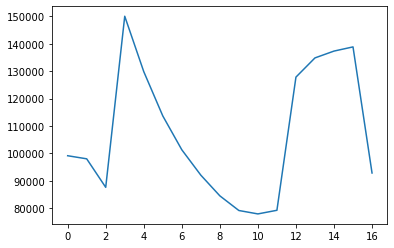

In [7]:
plt.plot(pi.bmoneys[-18:-1])